In [31]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns
%matplotlib inline

np.random.seed(sum(map(ord, "palettes")))
sns.set()
sns.set_style("darkgrid")


Plots we care about:

Classification accuracy on adversarial examples

Detection accuracy on adversarial examples

Detection accuracy on real images

Semi-supervised accuracy on real examples

Confidence when classifying adversarial examples (correct)

Confidence when classifying adversarial examples (incorrect)

In [165]:
files = ['mcmc-1', 'mcmc-2', 'mcmc-4', 'mcmc-6', 'mcmc-2_basic_iterative', 'mcmc-4_basic_iterative', 'MLE_DCGAN', 'MLE_DCGAN_basic_iterative']

In [166]:
def detection(prob_vec):
    return int(np.exp(prob_vec[0])/np.sum(np.exp(prob_vec)) >= 0.5)

In [167]:
def true_positive(prob_vec, label):

    return int(np.argmax(prob_vec[1:]) == np.argmax(label))

In [168]:
data = dict()
data['adv_class_acc'] = []
data['adv_detec_acc'] = []
data['real_detec_acc'] = []
data['semi_class_acc'] = []
data['confidence_correct'] = []
data['confidence_incorrect'] = []

for fname in files:
    #adv_sup_accs = []
    adv_sup_accs_unf = [] #classification accuracy on adversarial
    #s_accs = []
    d_accs = [] #classification accuracy on non-adversarial
    class_0_prob_on_correct = []
    class_0_prob_on_incorrect = []
    adv_detec_accs = [] #detection accuracy on adver
    real_detec_accs = [] #detection accuracy on nonadver
    if 'MLE' in fname:
        for i in range(0,2000,100):        
            with np.load(fname+'/'+'results_'+str(i)+'.npz') as f:
                #adv_sup_accs.append(f['adv_sup_acc'])
                adv_sup_accs_unf.append(f['adv_sup_acc_unf'])

                #s_results = np.array([true_positive(p,l) for (p,l) in zip(f['s_logits'], f['lbls'])])
                d_results = np.array([true_positive(p,l) for (p,l) in zip(f['d_logits'], f['lbls'])])

                #s_accs.append((s_results[s_results>0]).shape[0]/s_results.shape[0])
                d_accs.append(100*(d_results[d_results>0]).shape[0]/d_results.shape[0])

                class_0_prob_on_correct.append(f['correct_uncertainty'])
                class_0_prob_on_incorrect.append(f['incorrect_uncertainty'])
                
                adv_detec_accs.append(100*(1-f['adv_acc']))
                
                detect_on_real_results = np.array([detection(p) for p in f['d_logits']])
                real_detec_accs.append(100*detect_on_real_results[detect_on_real_results>0].shape[0]/detect_on_real_results.shape[0])
    else:
        for i in range(100,2100,100):        
            with open(fname+'/'+"results_"+str(i)+".json") as f:
                res = json.load(f)
                adv_detec_accs.append(100*(1-np.array(res['adversarial_classification_accuracy'])))
                real_detec_accs.append(100*res['non_adversarial_classification_accuracy'])
                adv_sup_accs_unf.append(res['adversarial_unfilted_semi_supervised_acc'])
                d_accs.append(res['semi_supervised_acc'])
                class_0_prob_on_correct.append(res['adversarial_uncertainty_correct'])
                class_0_prob_on_incorrect.append(res['adversarial_uncertainty_incorrect'])
    
    data['adv_class_acc'].append((fname, adv_sup_accs_unf))
    data['adv_detec_acc'].append((fname, adv_detec_accs))
    data['real_detec_acc'].append((fname, real_detec_accs))
    data['semi_class_acc'].append((fname, d_accs))
    data['confidence_correct'].append((fname, class_0_prob_on_correct))
    data['confidence_incorrect'].append((fname, class_0_prob_on_incorrect))

In [169]:
for k,v in data.items():
    data[k] = dict(v)

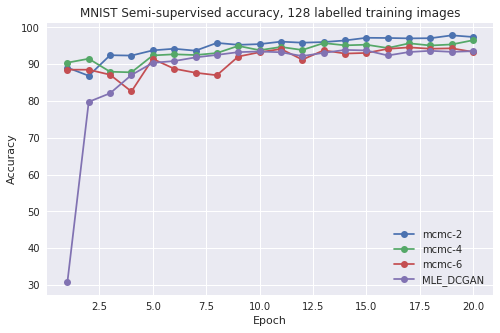

In [187]:
x = range(1,21)
plt.figure(figsize=(8,5))
plt.title('MNIST Semi-supervised accuracy, 128 labelled training images')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
for y in ['mcmc-2', 'mcmc-4', 'mcmc-6', 'MLE_DCGAN']:
    plt.plot(x,(data['semi_class_acc'])[y],'o-', label=y)
plt.legend()

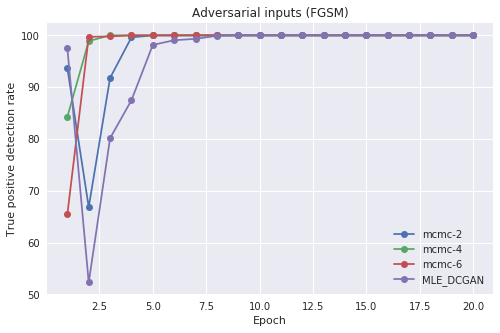

In [188]:
x = range(1,21)
plt.figure(figsize=(8,5))
plt.title('Adversarial inputs (FGSM)')
plt.ylabel('True positive detection rate')
plt.xlabel('Epoch')
for y in ['mcmc-2', 'mcmc-4', 'mcmc-6', 'MLE_DCGAN']:
    plt.plot(x,(data['adv_detec_acc'])[y],'o-', label=y)
plt.legend()

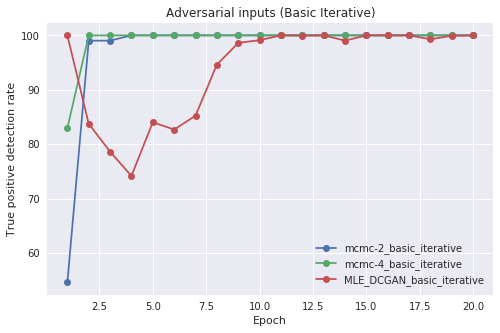

In [189]:
x = range(1,21)
plt.figure(figsize=(8,5))
plt.title('Adversarial inputs (Basic Iterative)')
plt.ylabel('True positive detection rate')
plt.xlabel('Epoch')
for y in ['mcmc-2_basic_iterative', 'mcmc-4_basic_iterative', 'MLE_DCGAN_basic_iterative']:
    plt.plot(x,(data['adv_detec_acc'])[y],'o-', label=y)
plt.legend()

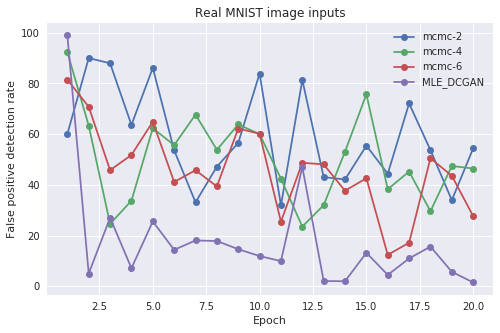

In [186]:
x = range(1,21)
plt.figure(figsize=(8,5))
plt.title('Real MNIST image inputs')
plt.ylabel('False positive detection rate')
plt.xlabel('Epoch')
for y in ['mcmc-2', 'mcmc-4', 'mcmc-6', 'MLE_DCGAN']:
    plt.plot(x,np.array((data['real_detec_acc'])[y]),'o-', label=y)
plt.legend()

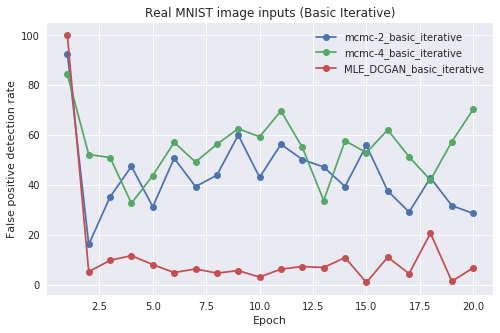

In [195]:
x = range(1,21)
plt.figure(figsize=(8,5))
plt.title('Real MNIST image inputs (Basic Iterative)')
plt.ylabel('False positive detection rate')
plt.xlabel('Epoch')
for y in ['mcmc-2_basic_iterative', 'mcmc-4_basic_iterative', 'MLE_DCGAN_basic_iterative']:
    plt.plot(x,np.array((data['real_detec_acc'])[y]),'o-', label=y)
plt.legend()

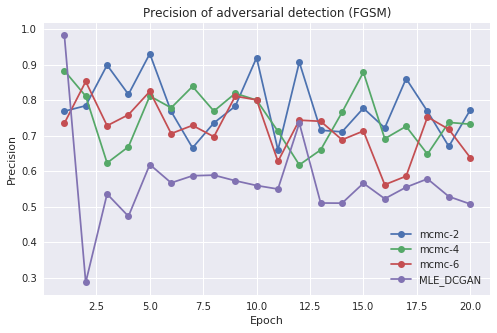

In [190]:
plt.figure(figsize=(8,5))
plt.title('Precision of adversarial detection (FGSM)')
plt.xlabel('Epoch')
plt.ylabel('Precision')
for y in ['mcmc-2', 'mcmc-4','mcmc-6', 'MLE_DCGAN']:
    plt.plot(x,(10000*np.array(data['adv_detec_acc'][y])/100
                +10000*np.array(data['real_detec_acc'][y])/100)/20000,
             'o-', label=y)
plt.legend()

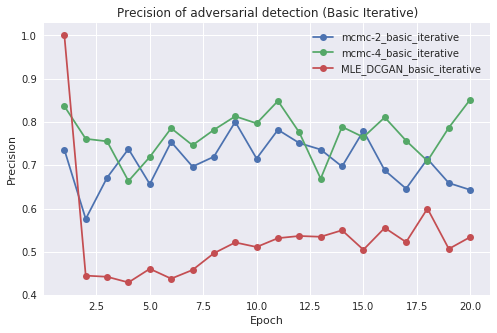

In [196]:
plt.figure(figsize=(8,5))
plt.title('Precision of adversarial detection (Basic Iterative)')
plt.xlabel('Epoch')
plt.ylabel('Precision')
for y in ['mcmc-2_basic_iterative', 'mcmc-4_basic_iterative', 'MLE_DCGAN_basic_iterative']:
    plt.plot(x,(10000*np.array(data['adv_detec_acc'][y])/100
                +10000*np.array(data['real_detec_acc'][y])/100)/20000,
             'o-', label=y)
plt.legend()

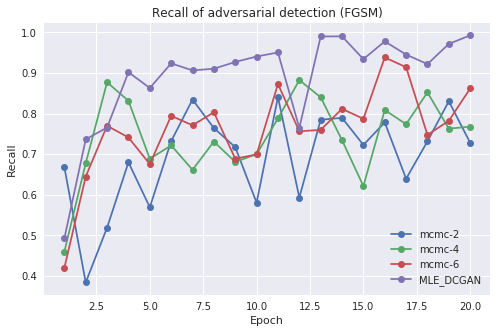

In [191]:
plt.figure(figsize=(8,5))
plt.title('Recall of adversarial detection (FGSM)')
plt.xlabel('Epoch')
plt.ylabel('Recall')
for y in ['mcmc-2', 'mcmc-4', 'mcmc-6', 'MLE_DCGAN']:
    plt.plot(x,(10000*np.array(data['adv_detec_acc'][y])/100
                +10000*(1-np.array(data['real_detec_acc'][y])/100))/20000,
             'o-', label=y)
plt.legend()

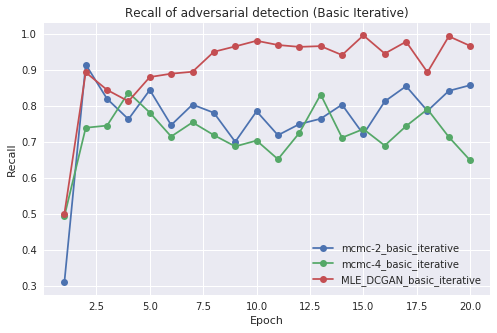

In [197]:
plt.figure(figsize=(8,5))
plt.title('Recall of adversarial detection (Basic Iterative)')
plt.xlabel('Epoch')
plt.ylabel('Recall')
for y in ['mcmc-2_basic_iterative', 'mcmc-4_basic_iterative', 'MLE_DCGAN_basic_iterative']:
    plt.plot(x,(10000*np.array(data['adv_detec_acc'][y])/100
                +10000*(1-np.array(data['real_detec_acc'][y])/100))/20000,
             'o-', label=y)
plt.legend()

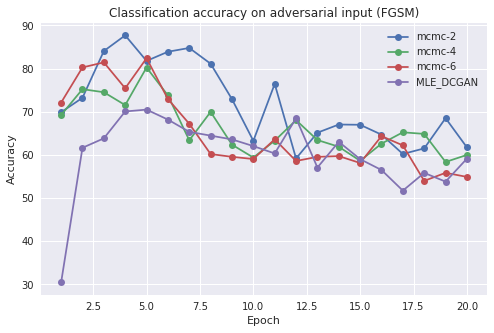

In [192]:
plt.figure(figsize=(8,5))
plt.title('Classification accuracy on adversarial input (FGSM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
for y in ['mcmc-2', 'mcmc-4', 'mcmc-6', 'MLE_DCGAN']:
    plt.plot(x,np.array(data['adv_class_acc'][y]),'o-', label=y)
plt.legend()

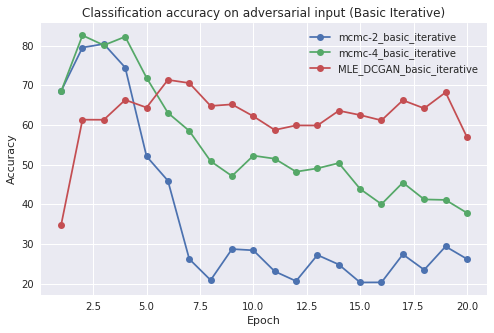

In [198]:
plt.figure(figsize=(8,5))
plt.title('Classification accuracy on adversarial input (Basic Iterative)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
for y in ['mcmc-2_basic_iterative', 'mcmc-4_basic_iterative','MLE_DCGAN_basic_iterative']:
    plt.plot(x,np.array(data['adv_class_acc'][y]),'o-', label=y)
plt.legend()

(0, 8)

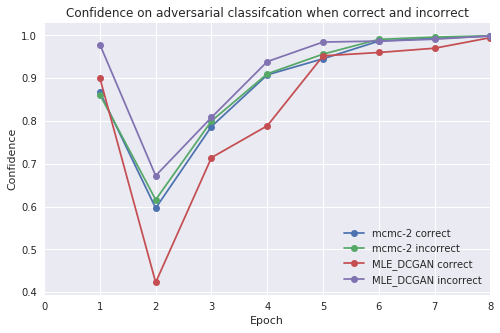

In [200]:
plt.figure(figsize=(8,5))
plt.title('Confidence on adversarial classifcation when correct and incorrect')
plt.xlabel('Epoch')
plt.ylabel('Confidence')
for y in ['mcmc-2', 'MLE_DCGAN']:
    plt.plot(x,np.array(data['confidence_correct'][y]),'o-', label=y+' correct')
    plt.plot(x,np.array(data['confidence_incorrect'][y]),'o-', label=y+' incorrect')
plt.legend()
plt.xlim([0,8])

(0, 8)

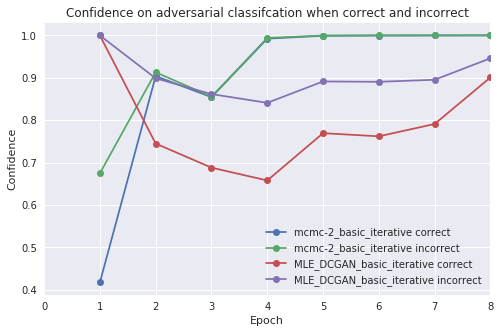

In [201]:
plt.figure(figsize=(8,5))
plt.title('Confidence on adversarial classifcation when correct and incorrect')
plt.xlabel('Epoch')
plt.ylabel('Confidence')
for y in ['mcmc-2_basic_iterative', 'MLE_DCGAN_basic_iterative']:
    plt.plot(x,np.array(data['confidence_correct'][y]),'o-', label=y+' correct')
    plt.plot(x,np.array(data['confidence_incorrect'][y]),'o-', label=y+' incorrect')
plt.legend()
plt.xlim([0,8])